In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "FAR1"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
r = min(5000/len(dataset_), 1)
_, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
#dataset = dataset_
dataset.head()

,id,sequence,length,class
9633,Neem_10606_f_1,MYTTESIIPESELALLESIRQFLLDDDLDVPITFPSETINAPLYSP...,252,0
6293,Sevir.2G333200.1.p,MSAAEDPSRLSGESSPSSPTSSGSSSPSSSGAATNLALTASTSAAG...,852,1
1831,Carubv10004178m,MDLQENQVSDAGDECMVGIMVESNSNRDVGIVDDLKAGGDLGFSGV...,786,1
4001,Migut.M00046.2.p,MAVTNIWVKRQQCPCGDWKCFVNYEADRDQATPVSQSVTNGCLSFP...,593,1
10152,PDK_30s928761g001,PEDCEIFSDVALNYISRMLMEEDIDEKVNSYQEESALQAAEKPFYE...,601,0


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
3312,0.009646,0.000000,0.006431,0.006431,0.000000,0.006431,0.000000,0.003215,0.012862,0.006431,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003215,0.0,0.000000
3849,0.004464,0.000000,0.001488,0.002976,0.007440,0.005952,0.000000,0.002976,0.000000,0.008929,...,0.008929,0.00000,0.000000,0.002976,0.001488,0.001488,0.001488,0.000000,0.0,0.001488
3258,0.049645,0.000000,0.007092,0.014184,0.007092,0.014184,0.000000,0.000000,0.007092,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.007092,0.000000,0.000000,0.0,0.000000
4799,0.008772,0.001462,0.002924,0.001462,0.002924,0.005848,0.004386,0.004386,0.004386,0.007310,...,0.004386,0.00000,0.001462,0.000000,0.002924,0.002924,0.005848,0.000000,0.0,0.000000
3007,0.011070,0.000000,0.003690,0.011070,0.003690,0.000000,0.003690,0.011070,0.000000,0.007380,...,0.003690,0.00369,0.000000,0.003690,0.000000,0.000000,0.003690,0.000000,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 603ms/step - accuracy: 0.4844 - loss: 0.6932

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5987 - loss: 0.6876   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6650 - loss: 0.6701 - val_accuracy: 0.9200 - val_loss: 0.3364


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8438 - loss: 0.3803

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9293 - loss: 0.2478 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9323 - loss: 0.2298 - val_accuracy: 0.9513 - val_loss: 0.1302


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1073

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9628 - loss: 0.1135 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9641 - loss: 0.1097 - val_accuracy: 0.9700 - val_loss: 0.0984


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0683

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0765 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9742 - loss: 0.0815 - val_accuracy: 0.9688 - val_loss: 0.1010


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0601

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9672 - loss: 0.0857 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9686 - loss: 0.0841 - val_accuracy: 0.9563 - val_loss: 0.1138


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.1066

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0590 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.0566 - val_accuracy: 0.9488 - val_loss: 0.1505


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0291

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0363

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0417 - val_accuracy: 0.9675 - val_loss: 0.0984


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0513

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.0389 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0409 - val_accuracy: 0.9712 - val_loss: 0.0888


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0061

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0274 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0305 - val_accuracy: 0.9688 - val_loss: 0.0939


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0033

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0341 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0325 - val_accuracy: 0.9700 - val_loss: 0.0998


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0078

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0264 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0301 - val_accuracy: 0.9712 - val_loss: 0.0984


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0176

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0187 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0229 - val_accuracy: 0.9625 - val_loss: 0.1225


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0191

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0248 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0261 - val_accuracy: 0.9675 - val_loss: 0.1162


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0099

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0203 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0186 - val_accuracy: 0.9588 - val_loss: 0.1447


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0161

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0086 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0097 - val_accuracy: 0.9663 - val_loss: 0.1187


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0023

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0124 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0130 - val_accuracy: 0.9688 - val_loss: 0.1285


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0028

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0058 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0072 - val_accuracy: 0.9413 - val_loss: 0.2393


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9688 - loss: 0.0618

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0213 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0213 - val_accuracy: 0.9700 - val_loss: 0.1144



[Train Accuracy: 99.37% - Test Accuracy: 97.30%]


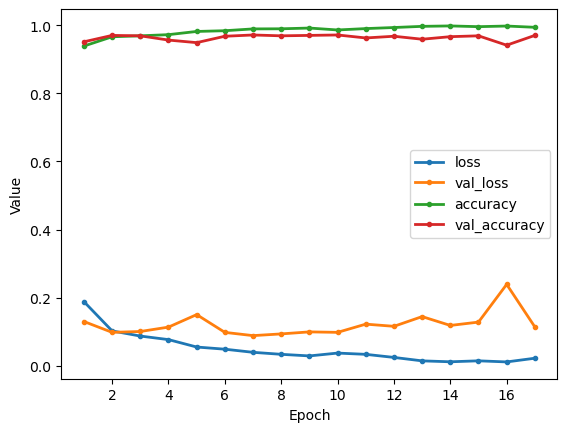

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3312,0.003226,0.000000,0.0,0.000000,0.000000,0.003226,0.000000,0.003226,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3849,0.000000,0.000000,0.0,0.000000,0.000000,0.001490,0.000000,0.000000,0.0,0.0,...,0.00149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3258,0.021429,0.000000,0.0,0.000000,0.007143,0.007143,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,0.002928,0.001464,0.0,0.000000,0.000000,0.001464,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,0.003704,0.000000,0.0,0.003704,0.000000,0.000000,0.003704,0.000000,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8755)
X_test: (1000, 8755)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,241,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,284,801 (8.72 MB)

 Trainable params: 2,284,801 (8.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 609ms/step - accuracy: 0.5156 - loss: 0.6931

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5183 - loss: 0.6932  

14/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5415 - loss: 0.6928 

21/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5720 - loss: 0.6918

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6023 - loss: 0.6897

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6287 - loss: 0.6861

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6540 - loss: 0.6789

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6760 - loss: 0.6679 - val_accuracy: 0.9750 - val_loss: 0.2564


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9375 - loss: 0.2683

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9558 - loss: 0.2366 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9638 - loss: 0.2042

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9684 - loss: 0.1809

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9711 - loss: 0.1635

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9727 - loss: 0.1505

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9740 - loss: 0.1398

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9743 - loss: 0.1375 - val_accuracy: 0.9862 - val_loss: 0.0430


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0046

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0136 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9947 - loss: 0.0156

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9949 - loss: 0.0159

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.0154

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9955 - loss: 0.0149

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0145

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9957 - loss: 0.0144 - val_accuracy: 0.9875 - val_loss: 0.0316


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0025

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0036 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0045

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9986 - loss: 0.0049

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0049

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0048

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0047

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9862 - val_loss: 0.0283


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.0828e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011     

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

23/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9862 - val_loss: 0.0305


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.4299e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011     

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9912 - val_loss: 0.0301


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.4937e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4412e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5876e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3241e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2385e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1733e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1031e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0839e-04 - val_accuracy: 0.9912 - val_loss: 0.0301


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.2893e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5597e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7461e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6829e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6689e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7035e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7793e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8001e-04 - val_accuracy: 0.9912 - val_loss: 0.0305


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.0727e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3615e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6579e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9622e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4088e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5497e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5176e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4826e-04 - val_accuracy: 0.9862 - val_loss: 0.0343


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3600e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7126e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3172e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5195e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5719e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5823e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5921e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5880e-04 - val_accuracy: 0.9875 - val_loss: 0.0335


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 2.9959e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7052e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2903e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1994e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3485e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5230e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6108e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6233e-04 - val_accuracy: 0.9887 - val_loss: 0.0342


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.2670e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8048e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6837e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.2934e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1048e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9653e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8489e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7959e-04 - val_accuracy: 0.9875 - val_loss: 0.0355


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.6787e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3159e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4146e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4302e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4230e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3995e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3804e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3728e-04 - val_accuracy: 0.9887 - val_loss: 0.0346


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.3007e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2825e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1595e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1360e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3185e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4511e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5158e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5253e-04 - val_accuracy: 0.9887 - val_loss: 0.0365


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 6.2608e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1218e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1082e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2796e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3731e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3980e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4042e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4031e-04 - val_accuracy: 0.9900 - val_loss: 0.0330


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.8104e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.9925e-05 

15/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0017e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0026e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9849e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7973e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.2580e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6643e-05 - val_accuracy: 0.9900 - val_loss: 0.0403



[Train Accuracy: 100.00% - Test Accuracy: 98.90%]


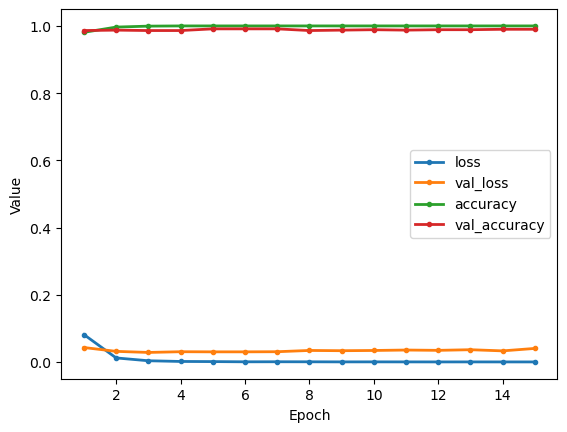

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
3312,0.000000,0.000000,0.0,0.0,0.0,0.003236,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3849,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3258,0.014388,0.000000,0.0,0.0,0.0,0.007194,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4799,0.000000,0.001466,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.003717,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,925,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,967,105 (144.83 MB)

 Trainable params: 37,967,105 (144.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 41s 853ms/step - accuracy: 0.4688 - loss: 0.6932

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.4648 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4731 - loss: 0.6932

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.4749 - loss: 0.6932

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.4737 - loss: 0.6932

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.4716 - loss: 0.6933

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.4721 - loss: 0.6933

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4741 - loss: 0.6933

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.4766 - loss: 0.6932

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4774 - loss: 0.6932

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4800 - loss: 0.6932

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4833 - loss: 0.6932

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4872 - loss: 0.6932

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.4917 - loss: 0.6931

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.4967 - loss: 0.6931

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5018 - loss: 0.6931

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5070 - loss: 0.6930

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5117 - loss: 0.6929

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5162 - loss: 0.6929

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5203 - loss: 0.6928

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5240 - loss: 0.6927

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.5273 - loss: 0.6926

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5308 - loss: 0.6925

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5340 - loss: 0.6924

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5368 - loss: 0.6923

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5396 - loss: 0.6921

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5422 - loss: 0.6920

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5444 - loss: 0.6918

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5466 - loss: 0.6917

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5488 - loss: 0.6915

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5509 - loss: 0.6913

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.5532 - loss: 0.6911

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5556 - loss: 0.6909

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.5581 - loss: 0.6907

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5607 - loss: 0.6904

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5633 - loss: 0.6901

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5659 - loss: 0.6899

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5685 - loss: 0.6896

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5712 - loss: 0.6892

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5739 - loss: 0.6889

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5767 - loss: 0.6885

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5795 - loss: 0.6882

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5823 - loss: 0.6877

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5852 - loss: 0.6873

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5880 - loss: 0.6868

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5908 - loss: 0.6864

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5935 - loss: 0.6858

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5963 - loss: 0.6853

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5991 - loss: 0.6847

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6018 - loss: 0.6840

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.6044 - loss: 0.6834 - val_accuracy: 0.9712 - val_loss: 0.4858


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 1.0000 - loss: 0.4664

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 0.4571 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9983 - loss: 0.4531

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9958 - loss: 0.4479

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9935 - loss: 0.4444

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9920 - loss: 0.4403

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9909 - loss: 0.4364

 8/50 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.9903 - loss: 0.4324

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9900 - loss: 0.4285

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9899 - loss: 0.4245

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9898 - loss: 0.4203

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9898 - loss: 0.4162

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9898 - loss: 0.4119

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9899 - loss: 0.4076

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9901 - loss: 0.4032

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9901 - loss: 0.3989

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9902 - loss: 0.3945

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9903 - loss: 0.3901

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9904 - loss: 0.3858

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9905 - loss: 0.3814

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9906 - loss: 0.3772

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9906 - loss: 0.3730

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9907 - loss: 0.3688

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9908 - loss: 0.3646

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9908 - loss: 0.3605

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9909 - loss: 0.3564

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9909 - loss: 0.3525

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9910 - loss: 0.3485

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9910 - loss: 0.3447

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9911 - loss: 0.3409

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9911 - loss: 0.3373

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9911 - loss: 0.3337

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9912 - loss: 0.3301

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9912 - loss: 0.3267

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9912 - loss: 0.3233

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9913 - loss: 0.3199

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9913 - loss: 0.3167

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9913 - loss: 0.3135

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9914 - loss: 0.3103

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9914 - loss: 0.3073

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9915 - loss: 0.3043

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.9915 - loss: 0.3013

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9915 - loss: 0.2984

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9916 - loss: 0.2956

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9916 - loss: 0.2928

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9916 - loss: 0.2901

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9917 - loss: 0.2874

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9917 - loss: 0.2848

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9917 - loss: 0.2822

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9918 - loss: 0.2797

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.9918 - loss: 0.2773 - val_accuracy: 0.9900 - val_loss: 0.0420


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 1.0000 - loss: 0.0091

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 0.0095 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0091

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 0.0088

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0085

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 0.0082

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0080

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0078

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0077

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0076

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0075

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0074

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 0.0074

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0073

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0072

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 0.0072

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0071

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0071

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0070

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0070

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0070

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0070

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0069

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 0.0069

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0069

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 0.0069

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0069

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0068

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0068

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0068

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0068

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.0068

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 0.0068

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9999 - loss: 0.0068

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0067

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0067

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0067

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0067

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0067

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0066

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0066

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9999 - loss: 0.0066

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9999 - loss: 0.0066

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0065

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0065

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0065

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9999 - loss: 0.0064

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9998 - loss: 0.0064

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9998 - loss: 0.0064

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9998 - loss: 0.0063

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9998 - loss: 0.0063 - val_accuracy: 0.9912 - val_loss: 0.0309


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 1.0000 - loss: 0.0025

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 0.0025

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0023

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 0.0023

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 0.0022

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 0.0021

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0021

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0020

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0020

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0020

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0019

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0019

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0019

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0018

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0018

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0018

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0018

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0018

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0017

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0017

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0017

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0017

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0017

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0017

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0017

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 0.0016

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0016

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0016

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0016

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0016

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0016

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0016

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0016

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 0.0015

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 0.0015

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0015

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0015

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0014

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0014

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0014

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0014

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9912 - val_loss: 0.0296


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 1.0000 - loss: 5.7330e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 8.7929e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 9.4816e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 9.5286e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.4087e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 9.2104e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 9.0442e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.8906e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 8.8064e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 8.7157e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 8.6173e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.5457e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.4622e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 8.3771e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.2935e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.2026e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.1182e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.0530e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 8.0150e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.9988e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.9771e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.9461e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.9140e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.8794e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.8422e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.8046e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7707e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7398e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.7090e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.6781e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.6445e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.6105e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 7.5787e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.5479e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.5156e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.4830e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 7.4504e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.4171e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.3846e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.3513e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.3188e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 7.2872e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.2567e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.2259e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.1955e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.1683e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.1412e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.1144e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.0883e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.0620e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.0366e-04 - val_accuracy: 0.9900 - val_loss: 0.0271


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 1.0000 - loss: 3.1821e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.4479e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 3.4976e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 3.4744e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.4897e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.4921e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.4993e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.4866e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.4723e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.4775e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.4817e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 3.4780e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.4678e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 3.4492e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4294e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4399e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4467e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4490e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 3.4470e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4455e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4418e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4421e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.4396e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 3.4359e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4355e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4331e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 3.4314e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4316e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4315e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4293e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4279e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4308e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4328e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 3.4337e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.4332e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.4321e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.4312e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.4306e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 3.4300e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.4281e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.4256e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 3.4230e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4206e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 3.4174e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4163e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4159e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4150e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4139e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4122e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 3.4104e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 3.4087e-04 - val_accuracy: 0.9900 - val_loss: 0.0264


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 1.0000 - loss: 1.2565e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.3531e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.5143e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.5901e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.6776e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7737e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.8362e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.8666e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8827e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.9111e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.9559e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.9850e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.0237e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0536e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.0817e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.1086e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.1290e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 2.1485e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1644e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 2.1775e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1922e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.2039e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.2121e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.2195e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.2243e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.2288e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2314e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.2326e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2331e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2325e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2315e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2304e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2283e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.2306e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2327e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2350e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2365e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2402e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2443e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2486e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2520e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 2.2557e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2585e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2604e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2622e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2703e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2775e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2838e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2901e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.2958e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.3013e-04 - val_accuracy: 0.9900 - val_loss: 0.0263


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 1.0000 - loss: 8.8769e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 1.0544e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.1085e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.2025e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.3144e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.3745e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4242e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4615e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.4809e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.4897e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.4926e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.4947e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.4920e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5024e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5073e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5139e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5175e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.5191e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5229e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.5245e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.5258e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.5266e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.5253e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.5242e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.5230e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.5208e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.5188e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.5167e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.5142e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.5113e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.5095e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.5074e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.5051e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.5037e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.5019e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.5001e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4984e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4964e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4963e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4962e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4966e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4967e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4965e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4960e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4953e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4943e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.4932e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.4921e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.4906e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.4890e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.4875e-04 - val_accuracy: 0.9900 - val_loss: 0.0263


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 1.0000 - loss: 1.5906e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4203e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.2918e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.2067e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1593e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1544e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.1469e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.1357e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.1257e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.1210e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.1128e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1062e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1063e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1046e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1021e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1088e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1131e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1169e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.1209e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1226e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1302e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.1361e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.1415e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1453e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1480e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1498e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.1506e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.1531e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1547e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1559e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.1563e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.1569e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.1571e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.1567e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1563e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1559e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1553e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1545e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1533e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1521e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1506e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 1.1489e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1471e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1450e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1432e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1415e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1406e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1395e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1385e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.1374e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.1363e-04 - val_accuracy: 0.9900 - val_loss: 0.0260


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 1.0000 - loss: 6.2810e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.6838e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.4893e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.3637e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 5.3888e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.7705e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.0748e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.3032e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.4374e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.5775e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.6757e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.8027e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.9997e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.1492e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.2586e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 7.3413e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.4057e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.4501e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.4915e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 7.5253e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.5575e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.5873e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 7.6138e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.6350e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.6481e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.6646e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.6766e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6834e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6896e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6951e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6954e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6950e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6927e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6876e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 7.6827e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 7.6798e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 7.6760e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 7.6709e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 7.6655e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 7.6584e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 7.6499e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 7.6451e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6398e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6352e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6295e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6230e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6159e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6105e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.6050e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 7.5996e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.5945e-05 - val_accuracy: 0.9900 - val_loss: 0.0260


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - accuracy: 1.0000 - loss: 5.1071e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.2263e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 5.2952e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 5.3959e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 5.7285e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.9294e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.0118e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.0375e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.0605e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.0486e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.0427e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.0225e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.9899e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.9625e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.1073e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.2135e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.2958e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.3730e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.4549e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5204e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5776e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.6420e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.6904e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.7372e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.7982e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.8558e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.9065e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.9507e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 6.9956e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 7.0324e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 7.0669e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 7.0973e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 7.1212e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 7.1430e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.1641e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.1840e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.2004e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.2164e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.2308e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.2443e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.2555e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 7.2656e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2726e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2790e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2831e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2860e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2897e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2920e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2936e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 7.2962e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 1.0000 - loss: 7.2987e-05 - val_accuracy: 0.9900 - val_loss: 0.0261


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.9711e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.9560e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.9399e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.3034e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.3919e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8566e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 6.1138e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.2597e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.3192e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 6.3780e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.4232e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.4473e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.4610e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.4958e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.5311e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.5493e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.5723e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.5879e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 6.5944e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5921e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5849e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5766e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5636e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5487e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5311e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 6.5203e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.5036e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.4894e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4777e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.4631e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4516e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.4365e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.4191e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 6.4084e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.3955e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.3816e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.3651e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.3490e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.3321e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.3149e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.2988e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.2818e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.2646e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.2472e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.2289e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.2107e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.1933e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.1753e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.1565e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 6.1379e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 6.1199e-05 - val_accuracy: 0.9900 - val_loss: 0.0261


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - accuracy: 1.0000 - loss: 4.2962e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 4.3918e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.3633e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.5447e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.5055e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.9453e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.1876e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.3641e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.4481e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.4937e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 5.5863e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 5.6354e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.6706e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.6949e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.7250e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.7394e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.7392e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.7295e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.7149e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.6914e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.6637e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.6363e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.6058e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.5762e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.5442e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.5103e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.4785e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.4492e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.4184e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.3932e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.3708e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.3601e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.3497e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.3460e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3420e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 5.3373e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3307e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3237e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3180e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 5.3118e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 5.3046e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 5.2976e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2908e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2856e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2829e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2788e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2753e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2707e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2651e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 5.2601e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 1.0000 - loss: 5.2554e-05 - val_accuracy: 0.9900 - val_loss: 0.0263



[Train Accuracy: 100.00% - Test Accuracy: 99.20%]


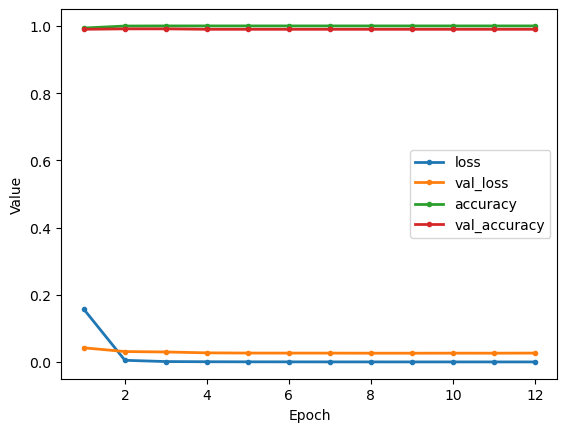

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

 9/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [26]:
report.save()

Report saved as Output/Reports/FAR1/report_MMIS8UA2.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################